<a href="https://colab.research.google.com/github/boangri/uai-thesis-notebooks/blob/main/notebooks/Pong_PyTorch_DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Решение задачи Pong методом DQN в PyTorch

In [ ]:
import os
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd 
import collections
import cv2
import matplotlib.pyplot as plt
import gym
import time

Классы сети и буфера воспроизведения опыта.

In [ ]:
class DeepQNetwork(nn.Module):
    def __init__(self, lr, n_actions, name, input_dims, chkpt_dir):
        super(DeepQNetwork, self).__init__()
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name)

        self.conv1 = nn.Conv2d(input_dims[0], 32, 8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, 3, stride=1)

        fc_input_dims = self.calculate_conv_output_dims(input_dims)

        self.fc1 = nn.Linear(fc_input_dims, 512)
        self.fc2 = nn.Linear(512, n_actions)

        self.optimizer = optim.RMSprop(self.parameters(), lr=lr)

        self.loss = nn.MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def calculate_conv_output_dims(self, input_dims):
        state = T.zeros(1, *input_dims)
        dims = self.conv1(state)
        dims = self.conv2(dims)
        dims = self.conv3(dims)
        return int(np.prod(dims.size()))

    def forward(self, state):
        conv1 = F.relu(self.conv1(state))
        conv2 = F.relu(self.conv2(conv1))
        conv3 = F.relu(self.conv3(conv2))
        # conv3 shape is BS x n_filters x H x W
        conv_state = conv3.view(conv3.size()[0], -1)
        # conv_state shape is BS x (n_filters * H * W)
        flat1 = F.relu(self.fc1(conv_state))
        actions = self.fc2(flat1)

        return actions

    def save_checkpoint(self):
        print('... saving checkpoint ...')
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        print('... loading checkpoint ...')
        self.load_state_dict(T.load(self.checkpoint_file))


class ReplayBuffer(object):
    def __init__(self, max_size, input_shape, n_actions):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.state_memory = np.zeros((self.mem_size, *input_shape),
                                     dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_shape),
                                         dtype=np.float32)

        self.action_memory = np.zeros(self.mem_size, dtype=np.int64)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = done
        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, batch_size, replace=False)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        terminal = self.terminal_memory[batch]

        return states, actions, rewards, states_, terminal



Классы-обертки

In [ ]:
class RepeatActionAndMaxFrame(gym.Wrapper):
    def __init__(self, env=None, repeat=4, clip_reward=False, no_ops=0,
                 fire_first=False):
        super(RepeatActionAndMaxFrame, self).__init__(env)
        self.repeat = repeat
        self.shape = env.observation_space.low.shape
        self.frame_buffer = np.zeros_like((2, self.shape))
        self.clip_reward = clip_reward
        self.no_ops = no_ops
        self.fire_first = fire_first

    def step(self, action):
        t_reward = 0.0
        done = False
        for i in range(self.repeat):
            obs, reward, done, info = self.env.step(action)
            if self.clip_reward:
                reward = np.clip(np.array([reward]), -1, 1)[0]
            t_reward += reward
            idx = i % 2
            self.frame_buffer[idx] = obs
            if done:
                break

        max_frame = np.maximum(self.frame_buffer[0], self.frame_buffer[1])
        return max_frame, t_reward, done, info

    def reset(self):
        obs = self.env.reset()
        no_ops = np.random.randint(self.no_ops)+1 if self.no_ops > 0 else 0
        for _ in range(no_ops):
            _, _, done, _ = self.env.step(0)
            if done:
                self.env.reset()
        if self.fire_first:
            assert self.env.unwrapped.get_action_meanings()[1] == 'FIRE'
            obs, _, _, _ = self.env.step(1)

        self.frame_buffer = np.zeros_like((2,self.shape))
        self.frame_buffer[0] = obs

        return obs

class PreprocessFrame(gym.ObservationWrapper):
    def __init__(self, shape, env=None):
        super(PreprocessFrame, self).__init__(env)
        self.shape = (shape[2], shape[0], shape[1])
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0,
                                    shape=self.shape, dtype=np.float32)

    def observation(self, obs):
        new_frame = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)
        resized_screen = cv2.resize(new_frame, self.shape[1:],
                                    interpolation=cv2.INTER_AREA)
        new_obs = np.array(resized_screen, dtype=np.uint8).reshape(self.shape)
        new_obs = new_obs / 255.0

        return new_obs

class StackFrames(gym.ObservationWrapper):
    def __init__(self, env, repeat):
        super(StackFrames, self).__init__(env)
        self.observation_space = gym.spaces.Box(
                            env.observation_space.low.repeat(repeat, axis=0),
                            env.observation_space.high.repeat(repeat, axis=0),
                            dtype=np.float32)
        self.stack = collections.deque(maxlen=repeat)

    def reset(self):
        self.stack.clear()
        observation = self.env.reset()
        for _ in range(self.stack.maxlen):
            self.stack.append(observation)

        return np.array(self.stack).reshape(self.observation_space.low.shape)

    def observation(self, observation):
        self.stack.append(observation)

        return np.array(self.stack).reshape(self.observation_space.low.shape)

def make_env(env_name, shape=(84,84,1), repeat=4, clip_rewards=False,
             no_ops=0, fire_first=False):
    env = gym.make(env_name)
    env = RepeatActionAndMaxFrame(env, repeat, clip_rewards, no_ops, fire_first)
    env = PreprocessFrame(shape, env)
    env = StackFrames(env, repeat)

    return env


Универсальный класс DQN-агента

In [ ]:
class DQNAgent(object):
    def __init__(self, gamma, epsilon, lr, n_actions, input_dims,
                 mem_size, batch_size, eps_min=0.01, eps_dec=5e-7,
                 replace=1000, algo=None, env_name=None, chkpt_dir='tmp/dqn'):
        self.gamma = gamma
        self.epsilon = epsilon
        self.lr = lr
        self.n_actions = n_actions
        self.input_dims = input_dims
        self.batch_size = batch_size
        self.eps_min = eps_min
        self.eps_dec = eps_dec
        self.replace_target_cnt = replace
        self.algo = algo
        self.env_name = env_name
        self.chkpt_dir = chkpt_dir
        self.action_space = [i for i in range(n_actions)]
        self.learn_step_counter = 0

        self.memory = ReplayBuffer(mem_size, input_dims, n_actions)

        self.q_eval = DeepQNetwork(self.lr, self.n_actions,
                                    input_dims=self.input_dims,
                                    name=self.env_name+'_'+self.algo+'_q_eval',
                                    chkpt_dir=self.chkpt_dir)

        self.q_next = DeepQNetwork(self.lr, self.n_actions,
                                    input_dims=self.input_dims,
                                    name=self.env_name+'_'+self.algo+'_q_next',
                                    chkpt_dir=self.chkpt_dir)

    def choose_action(self, observation):
        if np.random.random() > self.epsilon:
            state = T.tensor([observation],dtype=T.float).to(self.q_eval.device)
            actions = self.q_eval.forward(state)
            action = T.argmax(actions).item()
        else:
            action = np.random.choice(self.action_space)

        return action

    def store_transition(self, state, action, reward, state_, done):
        self.memory.store_transition(state, action, reward, state_, done)

    def sample_memory(self):
        state, action, reward, new_state, done = \
                                self.memory.sample_buffer(self.batch_size)

        states = T.tensor(state).to(self.q_eval.device)
        rewards = T.tensor(reward).to(self.q_eval.device)
        dones = T.tensor(done).to(self.q_eval.device)
        actions = T.tensor(action).to(self.q_eval.device)
        states_ = T.tensor(new_state).to(self.q_eval.device)

        return states, actions, rewards, states_, dones

    def replace_target_network(self):
        if self.learn_step_counter % self.replace_target_cnt == 0:
            self.q_next.load_state_dict(self.q_eval.state_dict())

    def decrement_epsilon(self):
        self.epsilon = self.epsilon - self.eps_dec \
                           if self.epsilon > self.eps_min else self.eps_min

    def save_models(self):
        self.q_eval.save_checkpoint()
        self.q_next.save_checkpoint()

    def load_models(self):
        self.q_eval.load_checkpoint()
        self.q_next.load_checkpoint()

    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
            return

        self.q_eval.optimizer.zero_grad()

        self.replace_target_network()

        states, actions, rewards, states_, dones = self.sample_memory()
        indices = np.arange(self.batch_size)

        q_pred = self.q_eval.forward(states)[indices, actions]
        q_next = self.q_next.forward(states_).max(dim=1)[0]

        q_next[dones] = 0.0
        q_target = rewards + self.gamma*q_next

        loss = self.q_eval.loss(q_target, q_pred).to(self.q_eval.device)
        loss.backward()
        self.q_eval.optimizer.step()
        self.learn_step_counter += 1

        self.decrement_epsilon()


Цикл обучения

In [ ]:
%%time
path = '/content/drive/My Drive/weights/Pong/'

env = make_env('PongNoFrameskip-v4')
best_score = -np.inf
load_checkpoint = False
n_games = 120
agent = DQNAgent(gamma=0.99, epsilon=1.0, lr=0.0001,
                    input_dims=(env.observation_space.shape),
                    n_actions=env.action_space.n, mem_size=50000, eps_min=0.05,
                    batch_size=32, replace=1000, eps_dec=1e-5,
                    chkpt_dir=path, algo='DQNAgent',
                    env_name='PongNoFrameskip-v4')

if load_checkpoint:
    agent.load_models()

n_steps = 0
scores, eps_history, steps_array = [], [], []
startTime = time.time()
for i in range(n_games):
    done = False
    observation = env.reset()

    score = 0
    while not done:
        action = agent.choose_action(observation)
        observation_, reward, done, info = env.step(action)
        score += reward
        if not load_checkpoint:
            agent.store_transition(observation, action, reward, observation_, int(done))
            agent.learn()
        observation = observation_
        n_steps += 1
    scores.append(score)
    steps_array.append(n_steps)

    avg_score = np.mean(scores[-10:])
    print("ep:%d score:%.0f avg_score:%.2f best_score:%.2f epsilon:%.4f steps:%d time:%.1f" % (i+1, score, avg_score, best_score, agent.epsilon, n_steps, time.time() - startTime))
    with open(path + 'torch_dqn_history4.csv', 'a') as h: 
        h.write("%d,%.0f,%.2f,%.6f,%d,%.1f\n" % (i+1, score, avg_score, agent.epsilon, n_steps, time.time() - startTime))

    if avg_score > best_score:
        if not load_checkpoint:
           agent.save_models()
        best_score = avg_score

    eps_history.append(agent.epsilon)


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


ep:1 score:-19 avg_score:-19.00 best_score:-inf epsilon:0.9909 steps:944 time:11.0
... saving checkpoint ...
... saving checkpoint ...
ep:2 score:-19 avg_score:-19.00 best_score:-19.00 epsilon:0.9814 steps:1889 time:24.0
ep:3 score:-21 avg_score:-19.67 best_score:-19.00 epsilon:0.9729 steps:2739 time:34.4
ep:4 score:-20 avg_score:-19.75 best_score:-19.00 epsilon:0.9634 steps:3688 time:45.9
ep:5 score:-20 avg_score:-19.80 best_score:-19.00 epsilon:0.9544 steps:4592 time:56.9
ep:6 score:-19 avg_score:-19.67 best_score:-19.00 epsilon:0.9423 steps:5797 time:71.6
ep:7 score:-21 avg_score:-19.86 best_score:-19.00 epsilon:0.9344 steps:6590 time:81.4
ep:8 score:-21 avg_score:-20.00 best_score:-19.00 epsilon:0.9251 steps:7521 time:92.9
ep:9 score:-21 avg_score:-20.11 best_score:-19.00 epsilon:0.9163 steps:8401 time:103.7
ep:10 score:-21 avg_score:-20.20 best_score:-19.00 epsilon:0.9077 steps:9262 time:114.6
ep:11 score:-21 avg_score:-20.40 best_score:-19.00 epsilon:0.8989 steps:10146 time:125.5

График обучения

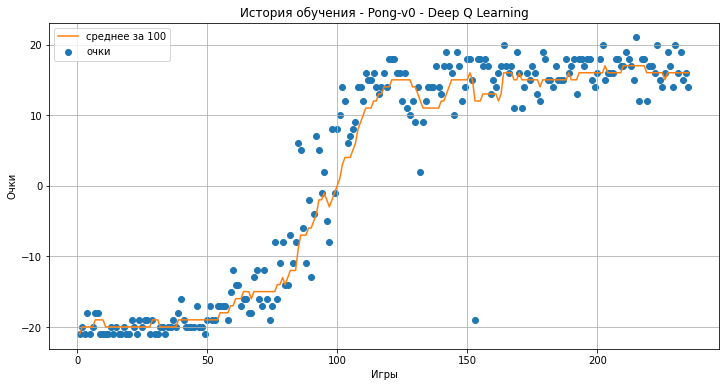

In [ ]:
path = '/content/drive/My Drive/weights/Pong/'

df = pd.read_csv(path + 'torch_dqn_history.csv', header=None, names=('episode', 'score', 'avg_score', 'epsilon', 'steps', 'time'))
x = df.episode
y = df.score
y1 = np.zeros_like(x)
for i in range(len(y1)):
    imin = i - 10 if i > 10 else 0
    y1[i] = y[imin:i+1].mean()
# y1 = df.avg_score
plt.figure(figsize=(12,6))
plt.scatter(x, y, label='очки')
plt.plot(x, y1, color='C1', label='среднее за 10')
plt.ylabel('Очки')
plt.xlabel('Игры')
plt.legend()
plt.grid()
plt.title('История обучения - Pong-v0 - Deep Q Learning')
plt.show()

Демонстрация игры

In [ ]:
%%time
path = '/content/drive/My Drive/weights/Pong/'

env = make_env('PongNoFrameskip-v4')
env.seed(3)
env = wrap_env(env)

load_checkpoint = True
n_games = 1
agent = DQNAgent(gamma=0.99, epsilon=0.0, lr=0.0001,
                    input_dims=(env.observation_space.shape),
                    n_actions=env.action_space.n, mem_size=1, eps_min=0.0,
                    batch_size=32, replace=1000, eps_dec=1e-5,
                    chkpt_dir=path, algo='DQNAgent',
                    env_name='PongNoFrameskip-v4')

if load_checkpoint:
    agent.load_models()

n_steps = 0
scores, eps_history, steps_array = [], [], []
startTime = time.time()
for i in range(n_games):
    done = False
    observation = env.reset()

    score = 0
    while not done:
        action = agent.choose_action(observation)
        observation, reward, done, info = env.step(action)
        score += reward
        n_steps += 1
    scores.append(score)
    steps_array.append(n_steps)

    avg_score = np.mean(scores[-10:])
    print(i+1, score)
print("avg_score=%.1f" % avg_score)
    # print("ep:%d score:%.0f avg_score:%.2f best_score:%.2f epsilon:%.4f steps:%d time:%.1f" % (i+1, score, avg_score, best_score, agent.epsilon, n_steps, time.time - startTime))
env.close()
show_video()

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


... loading checkpoint ...
... loading checkpoint ...
1 20.0
avg_score=20.0


CPU times: user 10.5 s, sys: 238 ms, total: 10.7 s
Wall time: 11 s
